In [1]:
import seaborn as sns
import pandas as pd
from pathlib import  Path
import matplotlib.pyplot as plt


report_directory = "/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT"
plot_saving_dir = "/media/kusterlab/internal_projects/active/TOPAS/Publications/Manuscript_MTB/Invests for Paper_Amir/3C"

def get_z_score_per_patient_per_protein_name_fp(patient,protein,df):
    col = 'zscore_' + patient
    return df.loc[df['Gene names']==protein,col] .tolist()[0]



def unnest_proteingroups(df:pd.DataFrame, column_split = 'Uniprot') -> pd.DataFrame:
    """
    Unnest the protein_groups A;B as two separate rows with the same intensity values for each
    the protein groups are the index of the the pandas dataframe df
    """
    temp_df = df
    temp_df['index'] = temp_df[column_split].str.split(';')
    temp_df = temp_df.explode('index')
    temp_df = temp_df.set_index('index')
    return temp_df
    



fp_measures_path = Path(report_directory) / Path('full_proteome_measures_z.tsv')
fp_measure_df = pd.read_csv(fp_measures_path,sep='\t')

basket_scores_path = Path(report_directory) / Path('basket_scores_4th_gen_zscored.tsv')
basket_scores_df = pd.read_csv(basket_scores_path,sep='\t')

In [2]:
list_proteins = {'EGFR':'EGFR',
                'FGFR':'FGFR1',
                'PDGFR':'PDGFRB',
                'IGF1R':'IGF1R',
                'AXL':'AXL',
                'EPHB3':'EPHB3',
                'EPHB4':'EPHB4',
                'EPH':'EPHB3;EPHB4',
                }

list_patients = [
                'H021-8DSJKN-T1-Q1','H021-VGVHN6-T3',
                'H021-WJQEW5-T1','I049-022-XT1-P1',
                'H021-3ZPN6C-M1-Q1','I007-126-1T1-P1',
                'I012-003-1T1-P1','H021-VDA4RJ-M1','I002-019-1T1-P1'
]

#  FP level

In [3]:
fp_measure_df = unnest_proteingroups(fp_measure_df,column_split='Gene names')
fp_measure_df['Gene names'] = fp_measure_df.index
fp_list_proteins = [x for x in list_proteins.values() if x in fp_measure_df['Gene names'].unique().tolist()]
fp_measure_df = fp_measure_df[fp_measure_df['Gene names'].isin(fp_list_proteins)]
fp_measure_df.columns = [x.replace('zscore_','') for  x  in fp_measure_df.columns]
fp_measure_df = pd.melt(fp_measure_df,id_vars=['Gene names'],value_name='Z-score',var_name='patient')
fp_measure_df['level'] = 'FP'


# TUPAC or basket level

In [4]:

basket_scores_df.set_index('Sample',inplace=True)
basket_list_proteins = [x for x in list_proteins.keys() if x in basket_scores_df.columns.tolist() ]
basket_scores_df = basket_scores_df[basket_list_proteins]
basket_scores_df = basket_scores_df.T

basket_scores_df['Gene names'] = basket_scores_df.index.map(list_proteins)
basket_scores_df = unnest_proteingroups(basket_scores_df,column_split='Gene names')
basket_scores_df['Gene names'] = basket_scores_df.index


basket_scores_df = pd.melt(basket_scores_df,id_vars=['Gene names'],value_name='Z-score',var_name='patient')
basket_scores_df['level'] = 'TUPAC'
background_df = pd.concat([fp_measure_df,basket_scores_df])
background_df = background_df.dropna(subset= ['Z-score'])
background_df = background_df.rename(columns={'Gene names':'protein'})
sub_patients_df = background_df[background_df['patient'].isin(list_patients)]

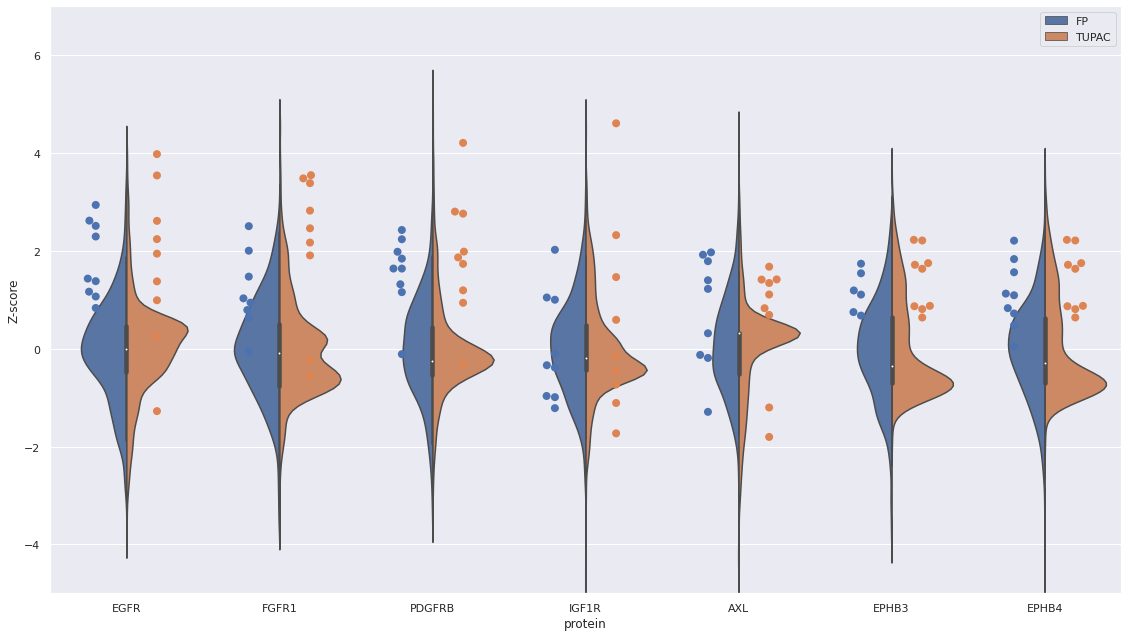

In [5]:
plot_saving_dir = "/media/kusterlab/internal_projects/active/TOPAS/Publications/Manuscript_MTB/Invests for Paper_Amir/3B"
fig = plt.figure(figsize=(19.20,10.80))
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('darkgrid', {'legend.frameon':True})
order = [x for x in list_proteins.values() if x in background_df.protein.unique().tolist()]
gfg = sns.violinplot(data = background_df, x = "protein", y = "Z-score", hue = "level", split = True,order=order)
legend = plt.legend(frameon=True)
sns.swarmplot(data = sub_patients_df,x = "protein", y = "Z-score",hue = "level",dodge = True,size = 8,legend=False,order=order)
gfg.set_ylim(-5, 7)

plt.savefig(f'{plot_saving_dir}/violin_plot_fp_tupac_pscores.svg',dpi=300)